# Previous tutorial
- [Colorspaces](https://www.kaggle.com/hrmello/intro-to-image-processing-colorspaces)

# Introduction
___
In the previous tutorial, we've seen what colorspaces are and how we can go from one to another using mathematical operations (or using OpenCV's functions as a blackbox to convert them). When we do something with a set of images, such as a classification or segmentation, it may -- and probably will -- happen that the images are not good enough to feed algorithms. We will need to preprocess them first. There are several preprocessing methods for images:
- Contrast adjustment
    - Histogram equalization
    - Contrast Limited Adaptive Histogram Equalization (CLAHE)
- Image filtering
    - Linear filters
    - Non-linear filters
    - Edge detection
    - Zooming
- Noise removal
    - Wiener filtering
    - Gaussian Blur

These are only a few of them and in this tutorial, in particular, we will focus on the first bullet point. But first we will need to understand why adjust contrast in an image at all. 

Contrast is the difference in visual properties that makes an object distinguishable from other objects and background. If we want to create an object detector, it seems reasonable to assume that we want objects in the scene as distringuishable as possible. 

For instance, let's take a look at this picture:
![](https://d1ro734fq21xhf.cloudfront.net/attachments/00V0B4-190321584.jpg)

Most of the man's face is black and we can't really see much besides his nose and mouth. Therefore if we want to develop, say, a face recognition algorithm and this is one of the images we will use (in either training or testing), we will probably want to enhance its contrast so we are able to get better details. 

# Histogram Equalization
___

In the context of image analysis, we can use histograms to understand the distribution of pixel intensities in the picture. In other words, its a graphical representation of the number of pixels for each possible intensity value -- usually ranging from 0 to 255. 

In low-contrast images, all pixels are close in intensity and this is what make the picture looks more or less the same with few distinguishable features. Our objective then is to stretch the histogram to either ends. This usually improves contrast, as there are more different intensities on the same image. Here is what it looks like:

![](https://docs.opencv.org/3.1.0/histogram_equalization.png)

Let's see that in practice using the image of three people below.

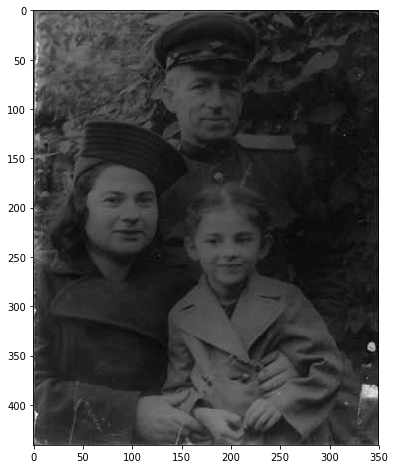

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io #scikit-image

# read the image from a link
# opencv doesn't directly read images from an url, so we will use
# skimage module to read it first
img = io.imread("http://www.dphclub.com/tutorials/images/war-time-1.jpg", as_gray=True)
plt.figure(figsize=(12,8))
plt.imshow(img, cmap="gray");

Although we can see all three people clearly, it doesn't have a good contrast, as the image as a whole is pretty dark. We can confirm this by looking at the image's histogram.

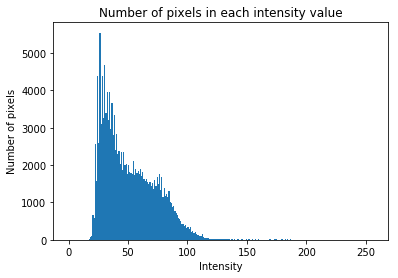

In [2]:
'''
NOTE: it is important to check the values of intensities before going on the analysis. 
Here, for instance, intensities are normalized, i.e. they range from 0 to 1 rather than 0 to 255,
so we need to convert it back to the latter so openCV works properly. That's why I multiply 
the entire image by 255 and convert it to np.uint8 (a format supported by OpenCV).
'''
# transform it to a numpy array 
img_arr = (np.round(np.array(img)*255)).astype(np.uint8)

# flatten
img_arr = img_arr.flatten()

# plot histogram
plt.hist(img_arr, bins = 256, range = [0,256])
plt.title("Number of pixels in each intensity value")
plt.xlabel("Intensity")
plt.ylabel("Number of pixels")
plt.show()

Now it becomes very apparent why there is low contrast in the image: From the 256 possible values to take, most pixels are between 20 and 100. 

Now let's equalize the histogram and see how both the image and the histogram looks like after that. 

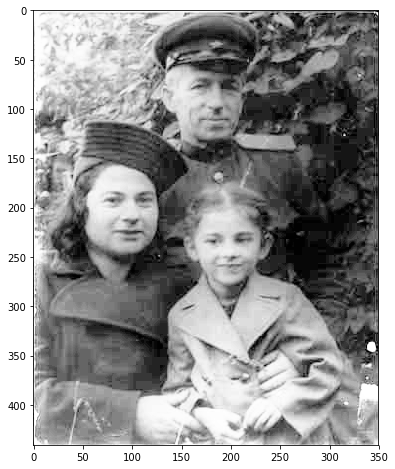

In [3]:
img_eq = cv2.equalizeHist((img*255).astype(np.uint8))
plt.figure(figsize=(12,8))
plt.imshow(img_eq, cmap = "gray");

Well, that's an improvement! Details like the folds on their coats and the background are much clearer now. 

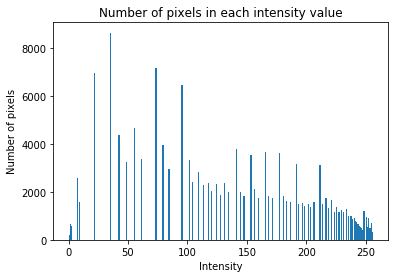

In [4]:
#get the numpy array for the equalized image
img_eq_arr = np.array(img_eq)

# flatten
img_eq_arr = img_eq_arr.flatten()

# plot histogram
plt.hist(img_eq_arr, bins = 256, range = [0,256])
plt.title("Number of pixels in each intensity value")
plt.xlabel("Intensity")
plt.ylabel("Number of pixels")
plt.show()

The equalized histogram confirms what we just saw in the picture. Now we have pixels' intensities ranging from 0 to 256, so we are able to distinguish more features as their intensities are more different than before. 

# Contrast Limited Adaptive Histogram Equalization (CLAHE)
___

Sometimes, however, using a simple Histogram Equalization (HE) may not provide a good outcome. This happens because it uses the same transformation derived from the image histogram to transform all pixels. This works well if the distribution of intensities is more or less the same across all the image, as it was in our test image above. However, there are situations in which this is not the case. For instance, take a look at the following image.
![](https://i.ibb.co/PzYwtD9/clahe-first.jpg)
The background is very dark whereas the head statue on the foreground is way brighter. What happens if we use HE here?

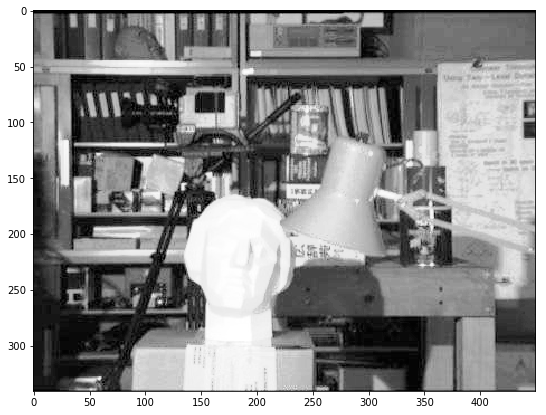

In [5]:
# read the image
img = io.imread("https://i.ibb.co/PzYwtD9/clahe-first.jpg", as_gray=True)
# use Histogram Equalization
img_eq = cv2.equalizeHist((img*255).astype(np.uint8))
# plot
plt.figure(figsize=(10,7))
plt.imshow(img_eq, cmap = "gray");

The background did became more detailed, but the foreground became excessively bright, which may cause some issues in our post-processing algorithms, such as a face recognition program. Here adaptive histogram equalization (AHE) can be used. In this, image is divided into small blocks called "tiles" (tileSize is 8x8 by default in OpenCV). Then each of these blocks are histogram equalized as usual.
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/AHE-neighbourhoods.svg/800px-AHE-neighbourhoods.svg.png" width="500" height="500">
This may turns out not so good as expected if there is noise in the image. If that's the case, it will only be amplified. To avoid this, contrast limiting should be applied -- and hence the full name of the technique. If any histogram bin is above the specified contrast limit (by default 40 in OpenCV), those pixels are clipped and distributed uniformly to other bins before applying histogram equalization. After equalization, to remove artifacts in tile borders, bilinear interpolation is applied.
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5f/Clahe-redist.svg/1920px-Clahe-redist.svg.png" width="500" height="500">

For a more detailed and mathematical explanation on how the interpolation works, check [this wiki page](https://en.wikipedia.org/wiki/Bilinear_interpolation) and its references.

So let's apply OpenCV's CLAHE and see how it turns out.

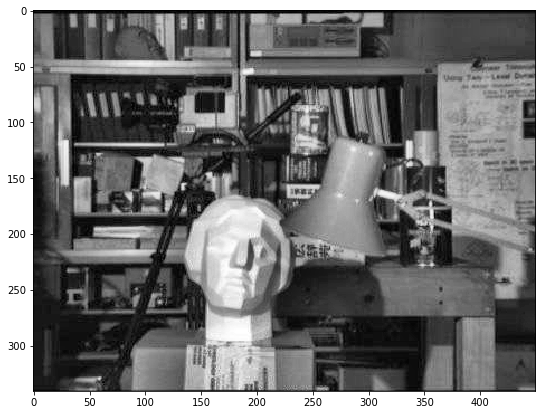

In [6]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe_img = clahe.apply((img*255).astype(np.uint8))
plt.figure(figsize=(10,7))
plt.imshow(clahe_img, cmap="gray");

Now both the background and foreground objects are distinguishable and the head is more detailed than without any processing.

# Try it yourself!
- Take an image in the Fruits 360 dataset, load it in grayscale and see if HE or CLAHE improves it. 
- If you are already familiar with the basics of convolutional neural networks for classification, you may try using a somewhat weak classifier with and without HE to check if there is some improvement in the model's performance just by using this technique. 

I left some code below that loads the dataset's images in grayscale. 

___

In [24]:
from sklearn.datasets import load_files
from keras.preprocessing.image import load_img
from tqdm import tqdm # progress bar

TRAIN_DIR = '../input/fruits-360_dataset/fruits-360/Training'
TEST_DIR = '../input/fruits-360_dataset/fruits-360/Test'

def load_dataset(path):
    '''
    Gets the path to the directory where 
    the image paths and return features, 
    targets and labels
    '''
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels
    
def convert_image_to_array(files):
    '''
    Take a file path as input and return the image in grayscale associated with that path.
    Returns an image in grayscale of size (100,100,1)
    '''
    images_as_array=[]
    for file in tqdm(files):
        # Convert to Numpy Array
        # np.expand_dims creates the channel dimension, that is
        # original shape: (100,100) | Final shape: (100,100,1)
        images_as_array.append(np.expand_dims(np.array((load_img(file, color_mode = "grayscale"))), axis=2))
        
        # uncomment the line below if you want to load colored images
        # but be aware that we need to be more careful to use HE and CLAHE
        # in colored images. See here for more detials: 
        # https://hypjudy.github.io/2017/03/19/dip-histogram-equalization/
#         images_as_array.append(np.array(load_img(file)))
    return images_as_array

# load train and test datasets
x_train, y_train,target_labels = load_dataset(TRAIN_DIR)
x_test, y_test,_ = load_dataset(TEST_DIR)

# convert the paths to actual images to be used in training
xtrain_img = np.array(convert_image_to_array(x_train))
xtest_img = np.array(convert_image_to_array(x_test))

100%|██████████| 17845/17845 [00:14<00:00, 1240.96it/s]
